<a href="https://colab.research.google.com/github/akalpit23/Explainable-techniques/blob/main/Assignment-5/Explainable_Techniques_Assignment_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #05



## Akalpit Dawkhar

### **Explainable Techniques**

### Overview
In this notebook, we used three different explainability techniques: LIME, AnchorImage, and Grad-CAM. Each of these techniques was chosen for its unique strengths in providing insights into the model's predictions.

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Explainable-techniques/Assignment-5/" # Change to your repo name
git_path = 'https://github.com/akalpit23/Explainable-techniques.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file'
!pip install -q -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Assignment-5/'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'Explainable-techniques'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 156 (delta 77), reused 95 (delta 37), pack-reused 0 (from 0)
Receiving objects: 100% (156/156), 6.29 MiB | 9.58 MiB/s, done.
Resolving deltas: 100% (77/77), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

# 1. Importing neccessary packages

In [15]:
import pandas as pd
import numpy as np
import torch
import xgboost as xgb
import shap
import lime
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
from torchvision.transforms import Compose, ToTensor, Normalize
from lime import lime_image
from sklearn.model_selection import train_test_split
from anchor import anchor_tabular
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from PIL import Image
from skimage.segmentation import mark_boundaries
from alibi.explainers import AnchorImage
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision import transforms

# 2. Load Sample Image and Resnet34 Model

In [3]:
!wget https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01532829_house_finch.JPEG -O /content/sample_image.jpg

!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O /content/imagenet_classes.txt

--2024-10-10 02:14:32--  https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01532829_house_finch.JPEG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78014 (76K) [image/jpeg]
Saving to: ‘/content/sample_image.jpg’

/content/sample_ima 100%[===================>]  76.19K  --.-KB/s    in 0.02s   

2024-10-10 02:14:32 (3.38 MB/s) - ‘/content/sample_image.jpg’ saved [78014/78014]

--2024-10-10 02:14:32--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response...

In [4]:
# Load pre-trained ResNet34 model
model = models.resnet34(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 89.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 3. Image Preprocessing

In [5]:
# Define image preprocessing steps (resize, normalize)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
# Load and preprocess the image
image_path = "sample_image.jpg"
image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(image).unsqueeze(0)


In [7]:
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [8]:
# Predict with the model
output = model(input_tensor)
_, pred_class = torch.max(output, 1)

# 4. LIME (Local Interpretable Model-agnostic Explanations)
**Strengths**: LIME is a versatile, model-agnostic explainer that can be used with any black-box model. It provides local explanations, helping us understand which parts of an image influence a specific prediction. The visualizations are easy to understand, highlighting the regions that are important for classification.

**Limitations**: LIME's explanations can be unstable, meaning that slight changes in the input may lead to different explanations. It is also computationally expensive, as it requires multiple perturbed samples to generate explanations.

**Potential Improvements**: To improve LIME's stability, ensemble approaches could be used where multiple explanations are averaged. Additionally, optimizing the number of perturbations can help balance between computational efficiency and accuracy.

In [33]:
# Define the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Function to predict the output of perturbed images for LIME
def predict_fn(images):
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in images])
    output = model(batch)
    return output.detach().numpy()

In [34]:
# Generate explanations for the prediction
explanation = explainer.explain_instance(np.array(image), predict_fn, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Visualizing LIME

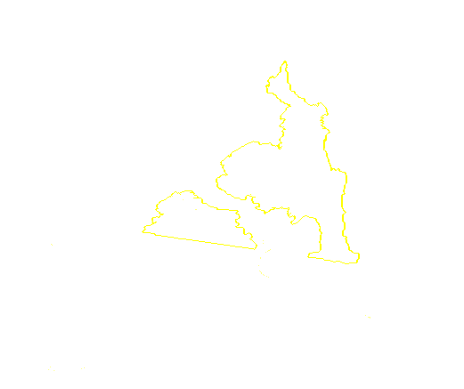

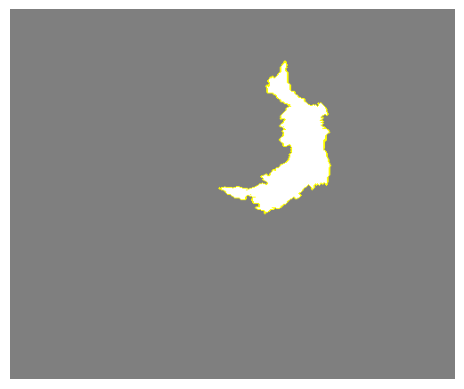

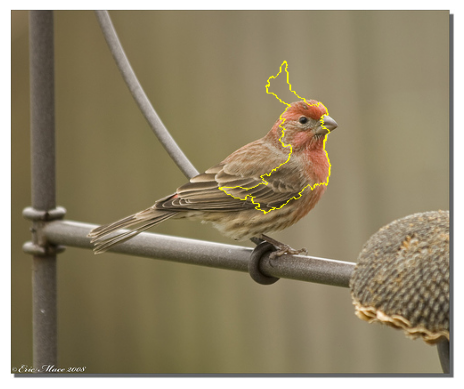

In [35]:
# Get the top predicted label from the explanation
top_label = explanation.top_labels[0]

# First visualization: Show explanation with positive_only=False, num_features=10, hide_rest=False
temp, mask = explanation.get_image_and_mask(top_label, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))  # Visualize the mask on the image
plt.axis('off')
plt.show()

# Second visualization: Show explanation with positive_only=True, num_features=5, hide_rest=True
temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))  # Visualize the mask on the image
plt.axis('off')
plt.show()

# Original visualization: Show explanation with positive_only=True, num_features=5, hide_rest=False
temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))  # Visualize the mask on the image
plt.axis('off')
plt.show()

# 5. Anchor Image
**Strengths**: AnchorImage provides high precision by identifying "anchors," which are subsets of features that are sufficient to guarantee a prediction with high confidence. This makes the explanations more trustworthy for understanding the regions that are most critical for a given prediction.

**Limitations**: AnchorImage can be difficult to apply in cases where image complexity is high, as it may generate anchors that are challenging to interpret. Additionally, the segmentation parameters can significantly impact the quality of the anchors, requiring careful tuning.

**Potential Improvements**: Better segmentation methods or using adaptive segmentation techniques could enhance the interpretability of anchors. Moreover, integrating user feedback to refine anchor generation can improve relevance and trustworthiness.


In [18]:
# Define your transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to PyTorch Tensor data type
])

pil_image = Image.open(image_path).convert("RGB")  # Load and convert image to RGB
image_tensor = transform(pil_image).unsqueeze(0)

In [19]:
def predict_anchor(images):
    batch = torch.stack([preprocess(Image.fromarray(img.astype(np.uint8))) for img in images])
    output = model(batch)
    return output.detach().numpy()  # Convert PyTorch tensor to numpy array

In [31]:
# Initialize the AnchorImage explainer
segmentation_fn = 'slic'
kwargs = {'n_segments': 10, 'compactness': 20, 'sigma': .6}  # Adjust segmentation parameters as needed
explainer = AnchorImage(predict_anchor, image_shape=(224, 224, 3), segmentation_fn=segmentation_fn,
                        segmentation_kwargs=kwargs)

# Explain the prediction for the input image (provide the image as a numpy array)
np_image = np.array(pil_image)
explanation = explainer.explain(np_image, threshold=0.95)


## Anchor Image Visulization

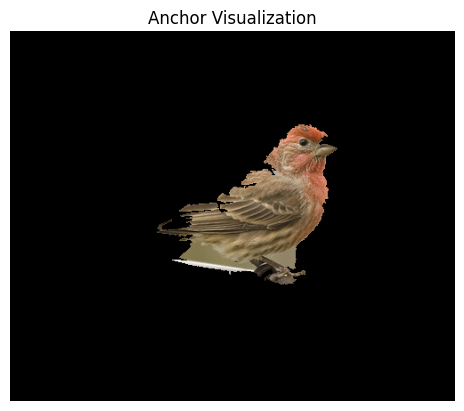

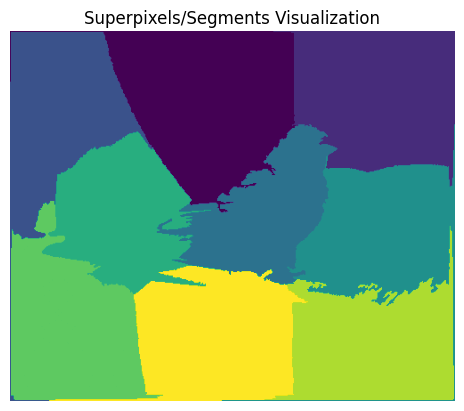

In [32]:
# Visualize the anchor
plt.imshow(explanation.anchor)
plt.title("Anchor Visualization")
plt.axis('off')  # Turn off axis
plt.show()

# Visualize the superpixels
plt.imshow(explanation.segments)
plt.title("Superpixels/Segments Visualization")
plt.axis('off')  # Turn off axis
plt.show()

# 3. Grad-CAM (Gradient-weighted Class Activation Mapping)
**Strengths**: Grad-CAM is effective for visualizing the parts of an image that contribute most to the model's predictions, especially for convolutional neural networks. It provides an intuitive heatmap that overlays on the original image, which is helpful for understanding how the model "sees" different classes.

**Limitations**: Grad-CAM is limited to convolutional models and only provides a coarse localization of important regions. It does not provide a complete understanding of the feature interactions that led to the prediction.

**Potential Improvements**: Combining Grad-CAM with other techniques such as Guided Backpropagation can provide more precise explanations. Additionally, using higher-resolution heatmaps or employing more sophisticated visualization techniques can improve the clarity of the results.

In [22]:
# Define target layers (usually the last convolutional layer)
target_layers = [model.layer4[-1]]

# Initialize the GradCAM explainer
cam = GradCAM(model=model, target_layers=target_layers)

# Define the target (e.g., class index 281 for 'tabby cat' in ImageNet)
targets = [ClassifierOutputTarget(281)]

# Generate the CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Resize the grayscale CAM to match the input image dimensions
grayscale_cam_resized = cv2.resize(grayscale_cam[0], (224, 224))


## Grad-CAM Visulization

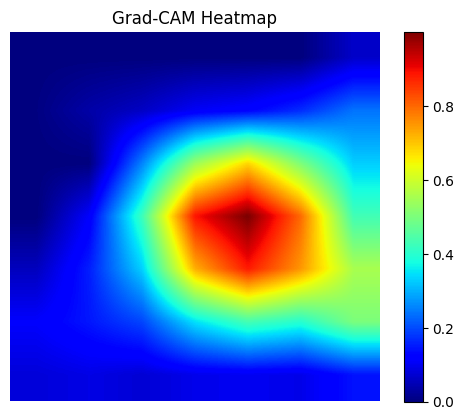

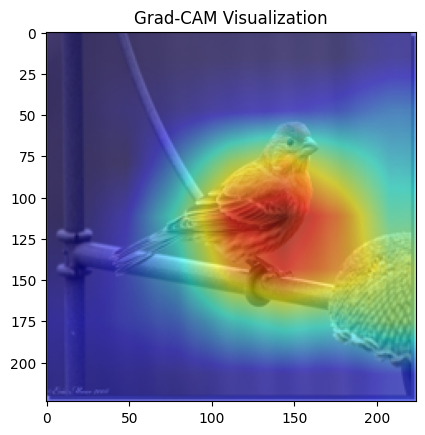

In [23]:
# Display only the Grad-CAM heatmap
plt.imshow(grayscale_cam_resized, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title('Grad-CAM Heatmap')
plt.show()

# Visualize the result
rgb_img = np.array(image.resize((224, 224)))
visualization = show_cam_on_image(rgb_img / 255.0, grayscale_cam_resized, use_rgb=True)

# Display the Grad-CAM visualization
plt.imshow(visualization)
plt.axis('on')
plt.title('Grad-CAM Visualization')
plt.show()

# 4. Conclusion
In this notebook, we used LIME, AnchorImage, and Grad-CAM to generate explanations for a pre-trained ResNet34 model's predictions on a sample image. Each technique provided unique insights into how the model interprets the image, helping us understand its behavior better. LIME offers model-agnostic, local interpretability, AnchorImage provides high-confidence feature regions, and Grad-CAM highlights the most influential areas in a convolutional manner. Together, these approaches offer a comprehensive understanding of the model's decision-making process.


### Comparison of Techniques
- **LIME** provides an intuitive, model-agnostic explanation, but can be unstable and computationally intensive. It is good for understanding local features but lacks the robustness needed for consistent results.
- **AnchorImage** offers a higher precision explanation by focusing on specific image segments that guarantee a prediction with high confidence. This precision makes it a reliable tool for understanding critical features of the model's decision-making process. It is especially useful when trust and precision are critical, as it provides clear and interpretable anchors that the model relies on.
- **Grad-CAM** is well-suited for convolutional neural networks and provides a coarse but effective heatmap that highlights important regions. It is particularly helpful for understanding which parts of an image influence predictions, but lacks the granularity needed for a full understanding of feature-level contributions.

### Why AnchorImage is the Best
AnchorImage stands out as the best technique among the three because it provides high-precision explanations that are easy to interpret and closely aligned with the model's confidence. By identifying specific segments that are crucial for the prediction, AnchorImage helps us gain a more reliable and trustworthy understanding of the model's decision-making process. This level of confidence in the explanation is particularly important in scenarios where model transparency is crucial, such as in medical or safety-critical applications. Additionally, while Grad-CAM and LIME provide useful insights, they either lack the precision (Grad-CAM) or the stability (LIME) that AnchorImage brings, making it the most effective method for understanding the critical features of the model's predictions.